In [1]:
import numpy as np
import cv2
import PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-03-20 11:52:05.823193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742442725.841437   73901 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742442725.847405   73901 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742442725.862294   73901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742442725.862347   73901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742442725.862350   73901 computation_placer.cc:177] computation placer alr

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
data_dir
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

'./datasets/flower_photos'

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

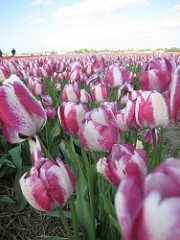

In [4]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [5]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [6]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [7]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
X = np.array(X)
y = np.array(y)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [10]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Load the pretrained model
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

I0000 00:00:1742442735.642658   73901 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1757 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
# Use built-in MobileNetV2 instead of Hub version
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Create the model
num_of_flowers = 5
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_of_flowers)(x)
model = tf.keras.Model(inputs, outputs)

# Summarize the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [15]:


model.fit(X_train_scaled, y_train, epochs=5, batch_size=3)

2025-03-20 11:52:24.199106: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1657012224 exceeds 10% of free system memory.
2025-03-20 11:52:25.058841: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1657012224 exceeds 10% of free system memory.


Epoch 1/5


I0000 00:00:1742442748.832597   74284 service.cc:152] XLA service 0x7c0b8c060180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742442748.832616   74284 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-20 11:52:28.924203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742442749.715785   74284 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-20 11:52:30.657905: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1346', 124 bytes spill stores, 124 bytes spill loads

2025-03-20 11:52:31.121664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

 23/918 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.1688 - loss: 1.9691       

I0000 00:00:1742442755.680976   74284 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


911/918 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6708 - loss: 0.8517

2025-03-20 11:52:43.081658: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 85.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-20 11:52:43.325799: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 93.35MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-20 11:52:43.563291: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 132.03MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-20 11:52:43.927168: W external/local_xla/xl

918/918 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - acc: 0.6717 - loss: 0.8495
Epoch 2/5
918/918 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.8959 - loss: 0.3013
Epoch 3/5
918/918 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.9168 - loss: 0.2359
Epoch 4/5
918/918 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.9459 - loss: 0.1561
Epoch 5/5
918/918 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.9615 - loss: 0.1221


In [16]:
model.evaluate(X_test_scaled,y_test)

2025-03-20 11:53:18.603202: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 212 bytes spill stores, 212 bytes spill loads

2025-03-20 11:53:18.671593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 84 bytes spill stores, 84 bytes spill loads

2025-03-20 11:53:19.340754: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 1604 bytes spill stores, 1604 bytes spill loads

2025-03-20 11:53:19.559466: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 5984 bytes spill stores, 5984 bytes spill loads

2025-03-20 11:53:24.137978: E 

27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.8410 - loss: 0.5368

2025-03-20 11:53:28.538943: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 224 bytes spill stores, 224 bytes spill loads

2025-03-20 11:53:28.599084: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 124 bytes spill stores, 124 bytes spill loads

2025-03-20 11:53:29.374899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 4808 bytes spill stores, 4932 bytes spill loads

2025-03-20 11:53:29.426151: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 5300 bytes spill stores, 5424 bytes spill loads

2025-03-20 11:53:33.165905: 

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - acc: 0.8403 - loss: 0.5372


[0.5388675928115845, 0.8333333134651184]